In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [3]:
import cv2
import numpy as np
import dlib
import matplotlib.pyplot as plt
import math
import skvideo.io as skv
import editdistance

In [4]:
face_detector = dlib.get_frontal_face_detector()
lip_detector = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

In [5]:
vid_path = "./videos/bbaf2n.mpg"

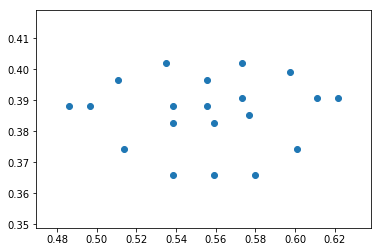

In [6]:
MOUTH_WIDTH = 128
MOUTH_HEIGHT = 64
HORIZONTAL_PAD = 0.19

vid = skv.vread(vid_path)
out = np.zeros((75,64,128,3))
    
out_landmark = np.zeros((75,40))
out_image = np.zeros((75,MOUTH_HEIGHT,MOUTH_WIDTH,3))
for i in range(vid.shape[0]):
    tmp_image = vid[i,:,:,:]
    rec_list, _, _  = face_detector.run(tmp_image,1)

    if len(rec_list) > 1:
        print("too many face")
        break
#         return -1
    elif len(rec_list) == 0:
        print("no face")
        break
#         return -1

    landmarks = lip_detector(tmp_image,rec_list[0]).parts()

    lip_point = np.array([[p.x,p.y] for p in landmarks[48:69]])
    mouth_centroid = np.mean(lip_point[:, -2:], axis=0)

    mouth_left = np.min(lip_point[:, :-1]) * (1.0 - HORIZONTAL_PAD)
    mouth_right = np.max(lip_point[:, :-1]) * (1.0 + HORIZONTAL_PAD)

    normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)
    new_img_shape = (int(tmp_image.shape[0] * normalize_ratio), int(tmp_image.shape[1] * normalize_ratio))
    tmp_image = cv2.resize(tmp_image,(new_img_shape[1],new_img_shape[0]))

    mouth_centroid_norm = mouth_centroid * normalize_ratio
    
    mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
    mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
    mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
    mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

    mouth_crop_image = tmp_image[mouth_t:mouth_b, mouth_l:mouth_r]

    out_image[i,:,:,:] = mouth_crop_image
    
    # landmark
    lip_point_norm = lip_point * normalize_ratio

    lip_point_norm[:,0] = lip_point_norm[:,0] / new_img_shape[0]
    lip_point_norm[:,1] = lip_point_norm[:,1] / new_img_shape[1]
    lip_point_norm = lip_point_norm.flatten()
            
            
    assert np.sum(lip_point_norm > 1) == 0

    out_landmark[i,:] = lip_point_norm
    
out_image = out_image/255.0   
out_landmark = out_landmark.reshape((75,20,2))
out_landmark[:,:,1] *= -1
out_landmark[:,:,1] += 1
plt.scatter(out_landmark[10,:,0], out_landmark[10,:,1])
out_landmark = out_landmark.reshape((75,40))

In [7]:
out_image.shape

(75, 64, 128, 3)

In [8]:
out_landmark.shape

(75, 40)

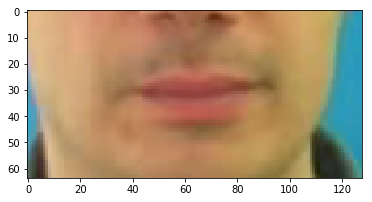

In [9]:
plt.imshow(out_image[0])

In [10]:
def drop_dup(l):
    out = [l[0]]
    for a in l[1:]:
        if a != out[-1]:
            out.append(a)
    return out

def text_decode(text):
    output = torch.softmax(text.cpu(),dim=-1).argmax(-1).numpy()
    txt = []
    for i in range(output.shape[0]):
        o = output[i]
        # TODO: Implement drop dup
        o = drop_dup(list(o))
        tmp_out = []
        for c in o:
            if int(c) != 0:
                tmp_out.append(idx2word[int(c)])
        txt.append("".join(tmp_out))
    return txt

In [11]:
# create dictionary
a_to_z = "abcdefghijklmnopqrstuvwxyz"

word2idx = dict()
idx2word = dict()

word2idx["RESERVE"] = 0
idx2word[0] = "RESERVE"

for c in a_to_z:
    word2idx[c] = len(word2idx)
    idx2word[len(idx2word)] = c
    
word2idx[" "] = len(word2idx)
idx2word[len(idx2word)] = " "

In [12]:
max_output_len = 32

In [13]:
class LipNet(torch.nn.Module):
    def __init__(self, dropout_p=0.5):
        super(LipNet, self).__init__()
        self.conv1 = nn.Conv3d(3, 32, (3, 5, 5), (1, 2, 2), (1, 2, 2))
        self.pool1 = nn.MaxPool3d((1, 2, 2), (1, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        
        self.conv2 = nn.Conv3d(32, 64, (3, 5, 5), (1, 1, 1), (1, 2, 2))
        self.pool2 = nn.MaxPool3d((1, 2, 2), (1, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        
        self.conv3 = nn.Conv3d(64, 96, (3, 3, 3), (1, 1, 1), (1, 1, 1))     
        self.pool3 = nn.MaxPool3d((1, 2, 2), (1, 2, 2))
        self.bn3 = nn.BatchNorm3d(96)
        
        self.feature_ex = nn.Linear(40, 128)
        self.gru1  = nn.GRU(96*4*8 + 128, 256, 1, bidirectional=True)
        self.gru2  = nn.GRU(512, 256, 1, bidirectional=True)
        
        self.FC    = nn.Linear(512, 27+1)
        self.dropout_p  = dropout_p

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.dropout_p)      
        self.dropout3d = nn.Dropout3d(self.dropout_p)  
        self._init()
    
    def _init(self):
        
        init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        init.constant_(self.conv1.bias, 0)
        
        init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        init.constant_(self.conv2.bias, 0)
        
        init.kaiming_normal_(self.conv3.weight, nonlinearity='relu')
        init.constant_(self.conv3.bias, 0)        
        
        init.kaiming_normal_(self.FC.weight, nonlinearity='sigmoid')
        init.constant_(self.FC.bias, 0)
        
        init.kaiming_normal_(self.feature_ex.weight, nonlinearity='sigmoid')
        init.constant_(self.feature_ex.bias, 0)
        
        for m in (self.gru1, self.gru2):
            stdv = math.sqrt(2 / (96*4*8 + 128 + 256))
            for i in range(0, 256 * 3, 256):
                init.uniform_(m.weight_ih_l0[i: i + 256],
                            -math.sqrt(3) * stdv, math.sqrt(3) * stdv)
                init.orthogonal_(m.weight_hh_l0[i: i + 256])
                init.constant_(m.bias_ih_l0[i: i + 256], 0)
                init.uniform_(m.weight_ih_l0_reverse[i: i + 256],
                            -math.sqrt(3) * stdv, math.sqrt(3) * stdv)
                init.orthogonal_(m.weight_hh_l0_reverse[i: i + 256])
                init.constant_(m.bias_ih_l0_reverse[i: i + 256], 0)
        
        
    def forward(self, x, landmark):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout3d(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.dropout3d(x)        
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.dropout3d(x)        
        x = self.pool3(x)
        
        # (B, C, T, H, W)->(T, B, C, H, W)
        x = x.permute(2, 0, 1, 3, 4).contiguous()
        # (B, C, T, H, W)->(T, B, C*H*W)
        x = x.view(x.size(0), x.size(1), -1)
        
        
        # concat landmark
        landmark = self.feature_ex(landmark)
        landmark = landmark.view((75,landmark.shape[0],128))
        x = torch.cat((x,landmark), 2)
        
        self.gru1.flatten_parameters()
        self.gru2.flatten_parameters()
        
        x, h = self.gru1(x)        
        x = self.dropout(x)
        x, h = self.gru2(x)   
        x = self.dropout(x)
                
        x = self.FC(x)
        x = x.permute(1, 0, 2).contiguous()
        return x

In [14]:
lipnet = LipNet().float().cuda()
lipnet.load_state_dict(torch.load("./weights/torch_improve_highlr_ep_111.pt"))

<All keys matched successfully>

In [15]:
images = torch.from_numpy(out_image[np.newaxis,:]).permute(0, 4, 1, 2, 3).cuda()
landmarks = torch.from_numpy(out_landmark[np.newaxis,:]).cuda()

lipnet.eval() ### not sure !!!!
outputs = lipnet(images.float(), landmarks.float())

txt_pred = text_decode(outputs.detach())

In [16]:
txt_pred

['bin blue an f two now']